In [22]:
import random
import copy

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import numpy as np

from sim import *

In [56]:
'''
MODEL PARAMETERS
'''

# Parameters for stochastic gene expression 
#
prot_activ_prob = 0.1  # probability of activation of promoter from inactive state
prot_deactiv_prob = 0.6  # probability of deactivation of promoter from active state

mrna_synth_rate = 100  # rate of mRNA transcription given active promoter (count / timestep)
mrna_degr_prob = 0.2  # probability of mRNA degradation
prot_synth_prob = 0.1  # probability of translation mRNA to protein
prot_degr_prob = 0.005  # probability of protein degradation

# Parameters for population behavior
#
n_pop = 50  # number of bacteria in the simulation
move_rad = 1  # radius of random movement of bacteria
div_prob = 0.05  # probability of cell division
lifetime = 50 

# Parameters for antibiotic treatment
#
add_antibio = 1  # add antibiotic (1) or not (0)
n_molec = 60  # number of antibiotic molecules
kill_radius = 3  # radius at which the antibiotic has effect
kill_prot_thres = 40 # minimum number of antibiotic-resistant proteins for bacteria to survive
intro_period = 20  # number of timesteps to introduce antibiotic molecules to the system

# Simulation parameters
# 
x_size = 50  # width of petri dish
y_size = 50  # height of petri dish

In [49]:
'''
AGENTS
'''

class Bacterium:
    # bacterium states
    prot_activ = False  # indicator variable if promoter is active
    mrna_count = 100
    prot_count = 1
    age = 0
    alive = True
    
    # coordinates
    x = None
    y = None
    
class Antibiotic:
    used = False  # if the molecule is consumed by an E. coli nearby
    
    # coordinates
    x = None
    y = None

In [50]:
'''
SIMULATION DYNAMICS
'''

def initialize():
    global bacteria, antibiotics, cell_counts, time
    
    bacteria = set()
    antibiotics = set()
    time = 1
    
    for i in range(n_pop):
        bact = Bacterium()
        bact.x = random.uniform(0, x_size)
        bact.y = random.uniform(0, y_size)
        
        bacteria.add(bact)
    cell_counts = [len(bacteria)]
        
def update():
    global bacteria, antibiotics, cell_counts, time
    
    if add_antibio == 1 and time % intro_period == 0:
        add_antibiotics()
    
    new_bacteria = set()
    for bact in bacteria:  # update states for each bacterium
        biosynth(bact)
        # print("after synth", count_alive(), "/", len(bacteria))
        
        move(bact)
        # print("after move", count_alive(), "/", len(bacteria))
        
        divide(bact, new_bacteria)
        # print("after divide", count_alive(), "/", len(bacteria))
        
        check_survival(bact)
        # print("after survival", count_alive(), "/", len(bacteria))
        
    bacteria.update(new_bacteria)
    clear_bacteria()  # remove dead bacteria
    clear_antibiotics()  # remove used antibiotics
    
    cell_counts.append(len(bacteria))
    time += 1
    
def add_antibiotics():
    global antibiotics
    
    for i in range(n_molec):
        anti = Antibiotic()
        anti.x = random.uniform(0, x_size)
        anti.y = random.uniform(0, y_size)
        
        antibiotics.add(anti)
        
def biosynth(bact):  # update mRNA and protein counts
    # transcription
    if bact.prot_activ == False:
        if random.random() < prot_activ_prob:
            bact.prot_active = True
    else:  # active promoter
        bact.mrna_count += mrna_synth_rate
        
        if random.random() < prot_deactiv_prob:
            bact.prot_active = False
        
    # translation and degradation of mRNA
    all_mrna = [0] * bact.mrna_count
    for i, _ in enumerate(all_mrna):
        p = random.random()
        if p < mrna_degr_prob:
            all_mrna[i] = 'degr'  # mark for degradation
        elif mrna_degr_prob <= p < mrna_degr_prob + prot_synth_prob:
            all_mrna[i] = 'trans'  # mark for translation
    
    bact.mrna_count -= all_mrna.count('degr') + all_mrna.count('trans')
    
    # synthesis and degradation of proteins
    all_prot = [0] * bact.prot_count
    for i, _ in enumerate(all_prot):
        p = random.random()
        if p < prot_degr_prob:
            all_prot[i] = 'degr'  # mark for degradation
    
    bact.prot_count += all_mrna.count('trans')
    bact.prot_count -= all_prot.count('degr')
    
def move(bact):  # move in the medium
    bact.x += random.uniform(-move_rad, move_rad)
    bact.y += random.uniform(-move_rad, move_rad)
    
    bact.x = max(0, min(bact.x, 50))
    bact.y = max(0, min(bact.y, 50))
    
def divide(bact, new_bacteria):  # cell division -> create a new cell nearby
    if random.random() < div_prob:
        new_bact = Bacterium()
        new_bact.x = random.uniform(0, x_size)  # max(0, min(bact.x + random.uniform(-move_rad, move_rad), 50))
        new_bact.y = random.uniform(0, y_size)  # max(0, min(bact.y + random.uniform(-move_rad, move_rad), 50))
        new_bacteria.add(new_bact)
    
def check_survival(bact):  # check if there are antibiotics nearby
    if bact.age > lifetime:
        bact.alive = False
    bact.age += 1
    
    for anti in antibiotics:
        if np.sqrt((anti.x - bact.x)**2 + (anti.y - bact.y)**2) <= kill_radius and bact.prot_count < kill_prot_thres:
            bact.alive = False
            anti.used = True
            break
    
def clear_bacteria():  # clear dead bacteria
    global bacteria
    bact_to_rm = set()
    
    for bact in bacteria:
        if bact.alive == False:
            bact_to_rm.add(bact)
    bacteria -= bact_to_rm    
    

def clear_antibiotics():  # clear used antibiotics
    global antibiotics
    anti_to_rm = set()
    
    for anti in antibiotics:
        if anti.used == True:
            anti_to_rm.add(anti)
    antibiotics -= anti_to_rm
    
def count_alive():
    global bacteria
    
    count = 0
    for bact in bacteria:
        if bact.alive:
            count += 1
            
    return count

In [51]:
'''
SIMULATION GRAPHICS
'''

max_prot_production = mrna_synth_rate * prot_activ_prob * prot_synth_prob * lifetime

def observe():
    global bacteria, antibiotics, cell_counts, time
    
    fig = plt.figure(figsize=(16, 10), dpi=150)
    gs = GridSpec(nrows=3, ncols=2)
    
    ax1 = fig.add_subplot(gs[:, 0])
    plot_petri(ax1)
    
    ax2 = fig.add_subplot(gs[0, 1])
    plot_cell_count(ax2)
    
    ax3 = fig.add_subplot(gs[1, 1])
    plot_prot_count_dist(ax3)
    
    ax4 = fig.add_subplot(gs[2, 1])
    plot_age_dist(ax4)
    
def plot_petri(ax):
    xs = [bact.x for bact in bacteria]
    ys = [bact.y for bact in bacteria]
    bright = [bact.prot_count for bact in bacteria] # brightness from marA expression
    
    cmap = plt.cm.Blues
    norm = colors.Normalize(vmin=0, vmax=max_prot_production)
    ax.scatter(xs, ys, color=cmap(norm(bright)))
    
    anti_xs = [anti.x for anti in antibiotics]
    anti_ys = [anti.y for anti in antibiotics]
    ax.scatter(anti_xs, anti_ys, color='red', s=1)
    ax.scatter(anti_xs, anti_ys, color='red', facecolors='none', edgecolors='r', s=kill_radius*400, alpha=0.1)
    
    ax.set_xlim(-1, x_size + 1)
    ax.set_ylim(-1, y_size + 1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Petri dish of E. coli and carbenicillin')
    
def plot_cell_count(ax):
    ax.plot(range(time), cell_counts)
    ax.set_xlabel('time')
    ax.set_ylabel('cell count')
    ax.set_title('E. coli count')
    
def plot_prot_count_dist(ax):
    prot_counts = []
    for bact in bacteria:
        prot_counts.append(bact.prot_count)
        
    ax.hist(prot_counts)
    ax.set_xlabel('protein count')
    ax.set_ylabel('cell count')
    
def plot_age_dist(ax):
    ages = []
    for bact in bacteria:
        ages.append(bact.age)
        
    ax.hist(ages)
    ax.set_xlabel('age')
    ax.set_ylabel('cell count')

# No antibiotic added

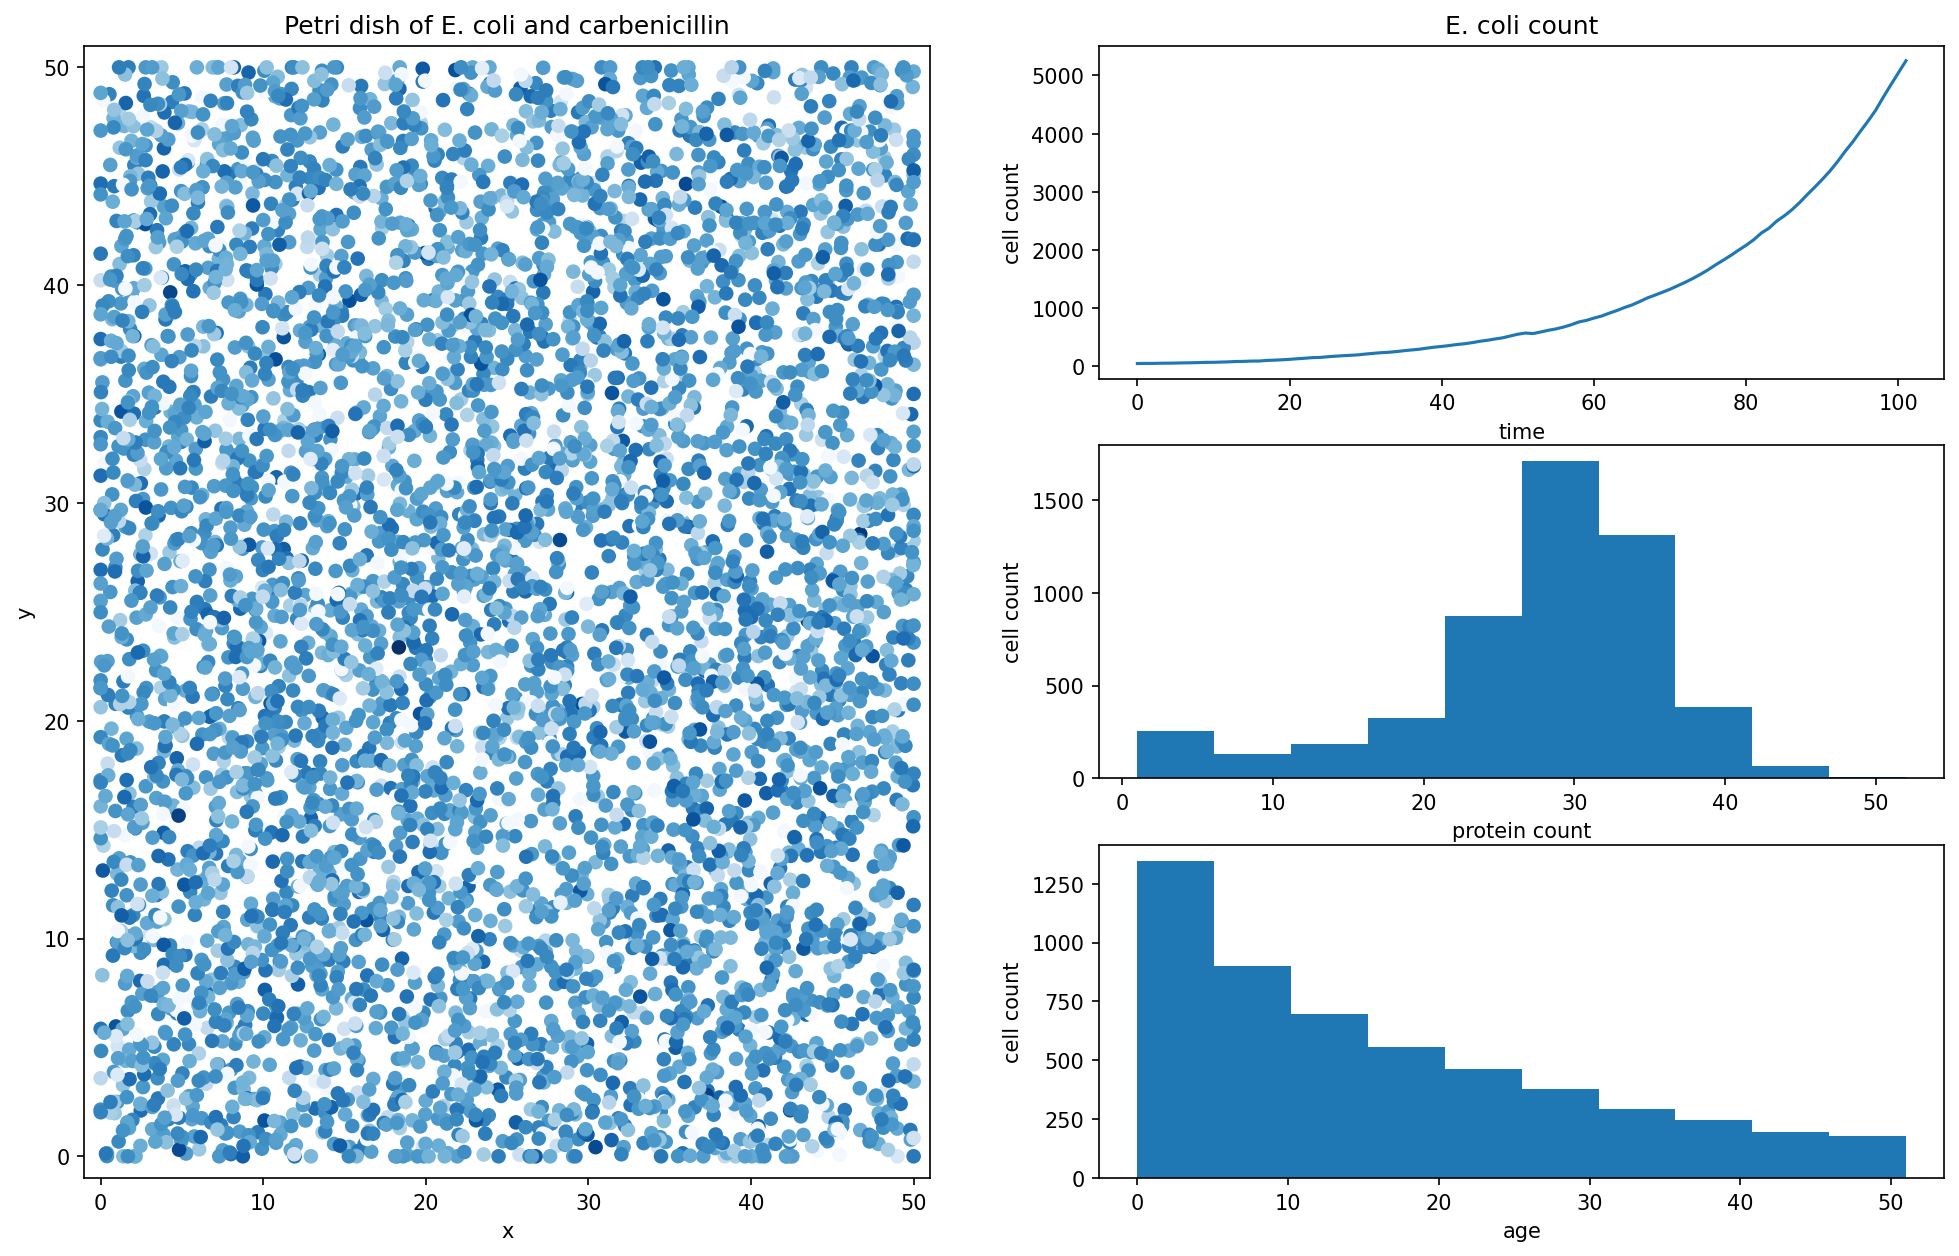

In [35]:
add_antibio = 0
initialize()

for i in range(101):
    update()
    
observe()

# Antibiotic added

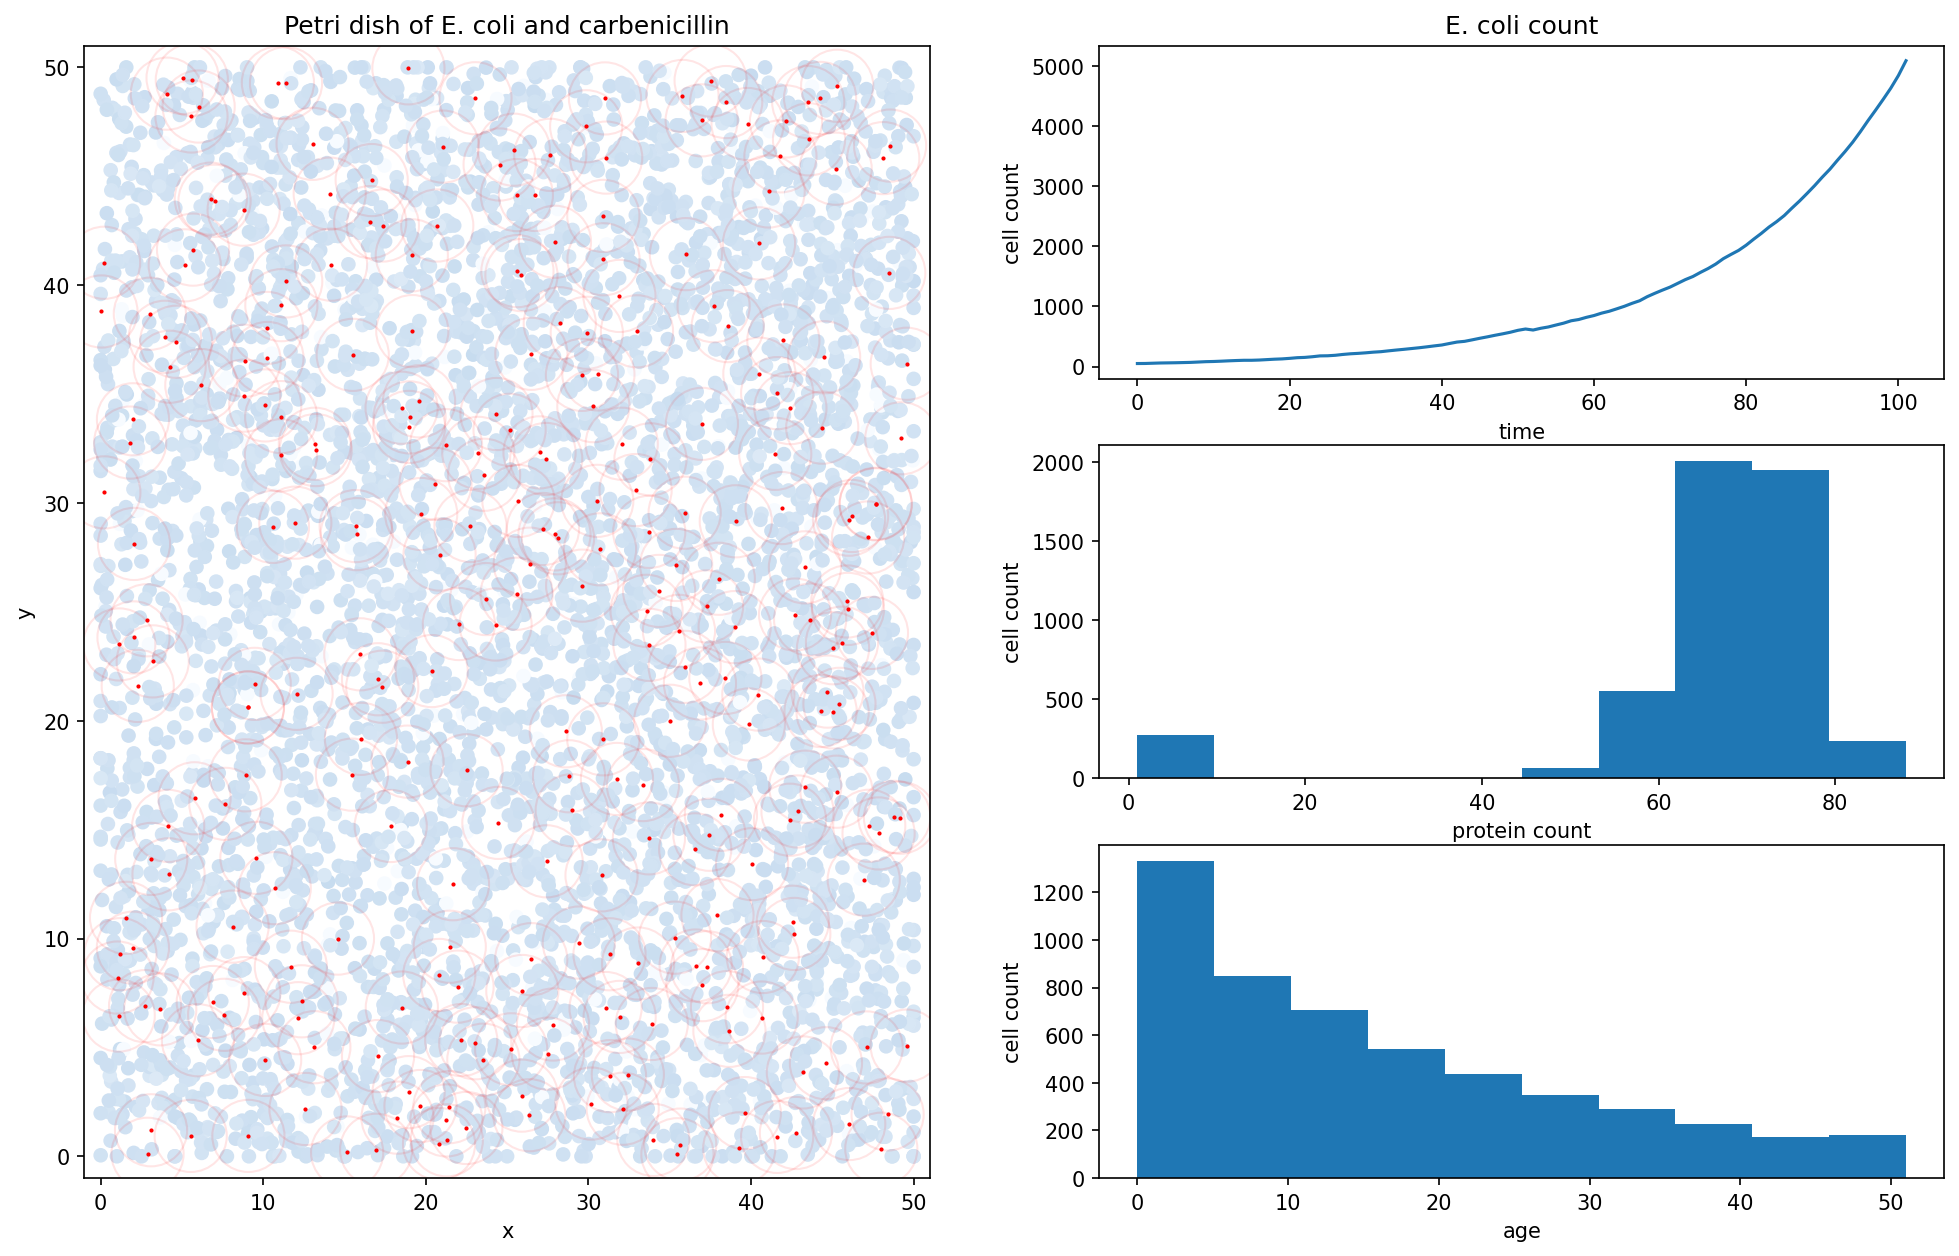

In [57]:
add_antibio = 1
initialize()

for i in range(101):
    update()
    
observe()